이미지 인식 정확도

In [4]:
import cv2
import numpy as np
from keras.models import load_model
from keras.layers import DepthwiseConv2D
import requests
import json
from bs4 import BeautifulSoup

def food_info(names):
    query = '+'.join(names)
    url = f"https://www.10000recipe.com/recipe/list.html?q={query}"
    response = requests.get(url)
    if response.status_code == 200:
        html = response.text
        soup = BeautifulSoup(html, 'html.parser')
    else:
        print("HTTP 응답 오류:", response.status_code)
        return

    food_list = soup.find_all(attrs={'class': 'common_sp_link'})
    if not food_list:
        print("식재료에 맞는 레시피가 없습니다.")
        return

    recipes = []

    for food in food_list[:5]:
        food_id = food['href'].split('/')[-1]
        new_url = f'https://www.10000recipe.com/recipe/{food_id}'
        new_response = requests.get(new_url)
        if new_response.status_code == 200:
            html = new_response.text
            soup = BeautifulSoup(html, 'html.parser')
        else:
            print("HTTP 응답 오류:", new_response.status_code)
            continue

        food_info = soup.find(attrs={'type': 'application/ld+json'})
        if food_info is not None:
            result = json.loads(food_info.text)
            ingredients = result.get('recipeIngredient', [])
            recipe = [step['text'] for step in result.get('recipeInstructions', [])]
            for i in range(len(recipe)):
                recipe[i] = f'{i + 1}. ' + recipe[i]

            view_count_element = soup.find(attrs={'class': 'view_count'})
            view_count = int(view_count_element.text.replace(',', '')) if view_count_element else 0

            print(f"레시피: {soup.title.string}")

            recipes.append({
                'title': soup.title.string,
                'ingredients': ingredients,
                'recipe': recipe,
                'view_count': view_count
            })

    if recipes:
        best_recipe = max(recipes, key=lambda x: x['view_count'])

        res = {
            'name': best_recipe['title'],
            'ingredients': ', '.join(best_recipe['ingredients']),
            'recipe': best_recipe['recipe']
        }
        return res
    else:
        print("적합한 레시피를 찾지 못했습니다.")
        return

# 모델과 라벨 로드
model = load_model("C:/Users/youngjin/Desktop/keras_model.h5", 
                   custom_objects={'DepthwiseConv2D': DepthwiseConv2D}, 
                   compile=False)

class_names = open("C:/Users/youngjin/Desktop/converted_keras/labels.txt", "r",encoding=("utf_8")).readlines()

# 웹캠 초기화
camera = cv2.VideoCapture(0)
is_recognizing = True
predicted_classes = []

while True:
    ret, image = camera.read()
    if not ret:
        print("웹캠 이미지 캡처 실패")
        break

    resized_image = cv2.resize(image, (224, 224))
    cv2.imshow("Webcam Image", resized_image)

    if is_recognizing:
        image = np.asarray(resized_image, dtype=np.float32)
        image = np.expand_dims(image, axis=0)
        image = image / 255.0

        prediction = model.predict(image)
        index = np.argmax(prediction)
        class_name = class_names[index].strip()
        confidence_score = prediction[0][index]

        print("Class:", class_name[2:], "Confidence Score:", str(np.round(confidence_score * 100))[:-2], "%")

        if confidence_score > 0.8:  # 낮은 신뢰도 예측을 피하기 위한 임계값 설정
            print(f"인식된 음식: {class_name[2:]}. 맞습니까? (y/n)")
            while True:
                keyboard_input = cv2.waitKey(1)
                if keyboard_input == ord('y'):
                    predicted_classes.append(class_name[2:])
                    print("추가할 식재료가 있습니까? (y/n)")
                    while True:
                        additional_input = cv2.waitKey(1)
                        if additional_input == ord('y'):
                            is_recognizing = True
                            break
                        elif additional_input == ord('n'):
                            is_recognizing = False
                            break
                        elif additional_input == 27:  # ESC 키를 누르면 종료
                            is_recognizing = False
                            break
                    break
                elif keyboard_input == ord('n'):
                    is_recognizing = True  # 인식을 계속 진행
                    break
                elif keyboard_input == 27:  # ESC 키를 누르면 종료
                    is_recognizing = False
                    break

    if not is_recognizing:
        break

camera.release()
cv2.destroyAllWindows()

if predicted_classes:
    print("예측된 식재료:", " ".join(predicted_classes))
    food_info_result = food_info(predicted_classes)
    if food_info_result:
        print("추천 레시피:")
        print("Food Name:", food_info_result["name"])
        print("Ingredients:", ", ".join(predicted_classes))
        print("Recipe:")
        for step in food_info_result['recipe']:
            print(step)
else:
    print("식재료를 인식하지 못했습니다.")


1/1 [==============================] - 1s 1s/step
Class: 치즈 Confidence Score: 92 %
인식된 음식: 치즈. 맞습니까? (y/n)
1/1 [==============================] - 0s 30ms/step
Class: 양파 Confidence Score: 100 %
인식된 음식: 양파. 맞습니까? (y/n)
추가할 식재료가 있습니까? (y/n)
1/1 [==============================] - 0s 28ms/step
Class: 치즈 Confidence Score: 100 %
인식된 음식: 치즈. 맞습니까? (y/n)
추가할 식재료가 있습니까? (y/n)
예측된 식재료: 양파 치즈
레시피: 양파치즈빵 만들기
레시피: 어니언 치즈 스콘 만들기｜효썸
레시피: 시금치 양파 치즈 스크램블에그 
레시피: 치아바타샌드위치 - 양파치즈샌드위치 
레시피: 지지고 볶아 달달한 양파가 치즈사이로 쏙! 양파치즈샌드위치
추천 레시피:
Food Name: 양파치즈빵 만들기
Ingredients: 양파, 치즈
Recipe:
1. [반죽] 양파를 사용할 때는 채 썰어서 사용해주세요.
2. 볼에 버터를 제외한 모든 재료를 넣고 손이나 반죽길 5분간 반죽해주세요.
3. 재료가 뭉쳐지기 시작하면 버터를 넣고 20분간 매끄럽게 반죽해주세요.
4. 따뜻한 곳(40℃)에 50분간 1차 발효시켜주세요.
5. 1차 발효 후.
6. 반죽을 4등분으로 나눠 둥글려주세요.
7. 랩을 덮어 15분간 중간발효 시켜주세요.
8. 0.5cm 두께가 되도록 길게 밀어주세요.
9. 돌돌 말아주세요.
10. 꼼꼼하게 마무리까지 했으면, 반죽의 윗면을 납작하게 눌러주세요.
11. 따뜻한 곳(40℃)에 30~40분간 2차 발효시켜주세요.
12. 2차 발효 후.
13. 가운데에 길게 칼집을 내주세요.(깊이 0.5~0.7cm 정도)
14. 채 썬 양파를 칼집을 기준으로 적당히 올려주세요.
15. 마요네즈를 짤주머니 또는 지퍼백에

findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon

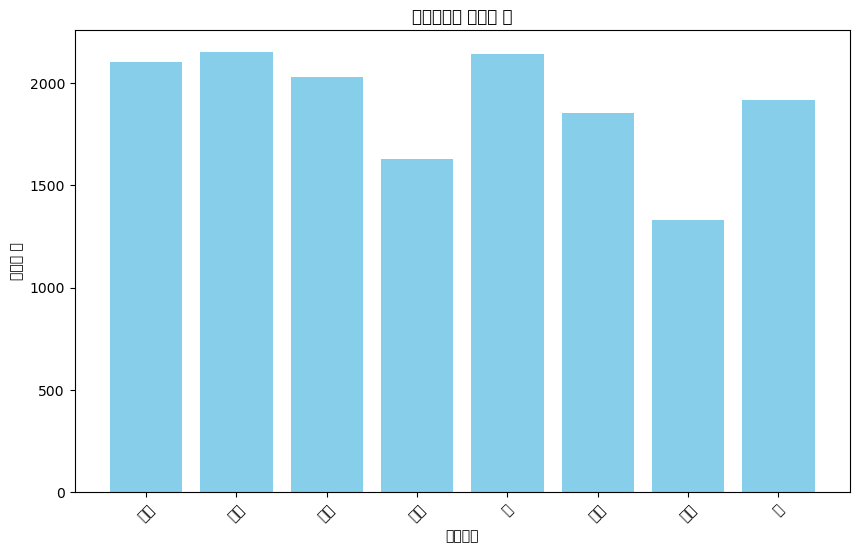

In [3]:
import os
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# NanumGothic-Regular 폰트 파일 경로 설정
font_path = 'C:/Users/youngjin/Desktop/Nanum_Gothic/NanumGothic-Regular.ttf'
if not os.path.exists(font_path):
    raise FileNotFoundError(f"Font file not found: {font_path}")

# 폰트 등록 및 설정
font_prop = fm.FontProperties(fname=font_path)
plt.rcParams['font.family'] = font_prop.get_name()

# 디렉토리 경로 설정
base_dir = "C:/Users/youngjin/Desktop/design/"

# 각 범주에 있는 이미지 파일 수를 세는 함수
def count_images_in_directories(base_dir):
    categories = []
    image_counts = []

    for category in os.listdir(base_dir):
        category_path = os.path.join(base_dir, category)
        if os.path.isdir(category_path):
            image_files = [f for f in os.listdir(category_path) if f.lower().endswith(('png', 'jpg', 'jpeg'))]
            categories.append(category)
            image_counts.append(len(image_files))

    return categories, image_counts

# 데이터 수집
categories, image_counts = count_images_in_directories(base_dir)

# 막대 그래프 그리기
plt.figure(figsize=(10, 6))
plt.bar(categories, image_counts, color='skyblue')
plt.xlabel('카테고리')
plt.ylabel('이미지 수')
plt.title('카테고리별 이미지 수')
plt.xticks(rotation=45)
plt.show()


model.h5의 정확도 확인

In [1]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score

In [2]:
model = load_model('C:/Users/youngjin/Desktop/CNN_model_1.h5')

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import json

# ImageDataGenerator를 사용하여 학습 데이터 로드 및 전처리
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    'C:/Users/youngjin/Desktop/design',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# 클래스 인덱스 확인 및 저장
class_indices = train_generator.class_indices
with open('class_indices.json', 'w') as f:
    json.dump(class_indices, f)

print(class_indices)  # 예: {'빵': 0, '케이크': 1, '쿠키': 2, ...}


Found 15164 images belonging to 8 classes.
{'감자': 0, '김치': 1, '달걀': 2, '마늘': 3, '빵': 4, '양파': 5, '치즈': 6, '파': 7}


In [12]:
# ImageDataGenerator를 사용하여 이미지 로드 및 전처리
datagen = ImageDataGenerator(rescale=1./255)

test_directory = 'C:/Users/youngjin/Desktop/accu' # "빵" 이미지가 있는 디렉토리 경로

test_generator = datagen.flow_from_directory(
    test_directory,
    target_size=(224, 224),  # 모델에 맞는 이미지 크기로 조정
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # 순서를 섞지 않음
)


Found 5475 images belonging to 7 classes.


In [10]:
# 예측 수행
predictions = model.predict(test_generator)
predicted_class_indices = np.argmax(predictions, axis=1)


ValueError: Asked to retrieve element 0, but the Sequence has length 0

In [12]:
# "빵" 클래스 인덱스 (예를 들어, 클래스 인덱스가 0이라고 가정)
bread_class_index = class_indices["감자"]

# 실제 레이블 생성 (모든 레이블이 "빵" 클래스인 경우)
true_labels = [bread_class_index] * len(predicted_class_indices)

# 정확도 계산
accuracy = accuracy_score(true_labels, predicted_class_indices)
print(f'정확도: {round(accuracy,4)}')


정확도: 0.15


In [14]:
datagen = ImageDataGenerator(rescale=1./255)

class_directories = ['감자', '김치', '달걀',"빵","치즈","양파","파"]  # 각 클래스 디렉토리 이름
accuracies = []

for class_dir in class_directories:
    test_directory = f'C:/Users/youngjin/Desktop/accu/{class_dir}'
    
    test_generator = datagen.flow_from_directory(
        test_directory,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        shuffle=False
    )
    
    # 모델 예측
    predictions = model.predict(test_generator)
    y_true = test_generator.classes
    y_pred = np.argmax(predictions, axis=1)
    
    # 클래스별 정확도 계산
    class_accuracy = accuracy_score(y_true, y_pred)
    accuracies.append(class_accuracy)
    print(f"Accuracy for {class_dir}: {class_accuracy:.2f}")

Found 4638 images belonging to 1 classes.
145/145 [==============================] - 54s 376ms/step
Accuracy for 감자: 0.92
Found 118 images belonging to 1 classes.
4/4 [==============================] - 1s 342ms/step
Accuracy for 김치: 0.00
Found 551 images belonging to 1 classes.
18/18 [==============================] - 7s 366ms/step
Accuracy for 달걀: 0.00
Found 107 images belonging to 1 classes.
4/4 [==============================] - 2s 480ms/step
Accuracy for 빵: 0.09
Found 14 images belonging to 1 classes.
1/1 [==============================] - 0s 211ms/step
Accuracy for 치즈: 0.00
Found 22 images belonging to 1 classes.
1/1 [==============================] - 0s 271ms/step
Accuracy for 양파: 0.09
Found 25 images belonging to 1 classes.
1/1 [==============================] - 0s 334ms/step
Accuracy for 파: 0.04


In [ ]:
# 전체 평균 정확도 계산
mean_accuracy = np.mean(accuracies)
print(f"Mean Accuracy: {mean_accuracy:.2f}")

낮은 이미지 인식률 계선을 위한 추가 학습

In [51]:
from keras.models import load_model, Model
from keras.layers import Dense, Flatten, DepthwiseConv2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from keras.layers import Flatten, Dense
from keras.models import Model

전이학습

In [87]:
# 기존 모델 로드
original_model = load_model("C:/Users/youngjin/Desktop/converted_keras/keras_model.h5", 
                            custom_objects={'DepthwiseConv2D': DepthwiseConv2D}, 
                            compile=False)

In [60]:
# 데이터 증강기 설정 (필요에 따라 설정)
datagen = ImageDataGenerator(rescale=1./255)
# 추가할 새로운 데이터 "빵"
bread_generator = datagen.flow_from_directory(
    "C:/Users/youngjin/Desktop/bread",
    target_size=(224, 224),  # 이미지 크기를 모델에 맞게 조정
    batch_size=32,
    class_mode='categorical'  # 다중 클래스 분류
)

Found 107 images belonging to 1 classes.


In [61]:
# 훈련 데이터 로드
train_generator = datagen.flow_from_directory(
    "C:/Users/youngjin/Desktop/design",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)


Found 2972 images belonging to 8 classes.


In [62]:
#X_existing_data, y_existing_data = train_generator.next()
# 데이터 합치기 용량 부족하여 제너레이터로 나눠서 진행
import numpy as np

def combined_generator(gen1, gen2):
    while True:
        X1, y1 = gen1.next()
        X2, y2 = gen2.next()
        X_combined = np.concatenate([X1, X2], axis=0)
        y_combined = np.concatenate([y1, y2], axis=0)
        yield X_combined, y_combined

# 새로운 훈련 데이터 제너레이터
combined_train_generator = combined_generator(train_generator, bread_generator)



In [63]:
# 데이터 증강기 설정 (예시)
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [88]:
original_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_7 (Sequential)   (None, 1280)              410208    
                                                                 
 sequential_9 (Sequential)   (None, 8)                 128900    
                                                                 
Total params: 539108 (2.06 MB)
Trainable params: 525028 (2.00 MB)
Non-trainable params: 14080 (55.00 KB)
_________________________________________________________________


In [89]:
# 중간 레이어 이름 확인
layer_name = 'sequential_7'

try:
    intermediate_layer = original_model.get_layer(layer_name)
    intermediate_layer_output = intermediate_layer.output
    inputs = original_model.input

    # 중간 레이어 모델 생성
    intermediate_layer_model = Model(inputs=inputs, outputs=intermediate_layer_output)
    intermediate_layer_model.summary()
except ValueError as e:
    print(f"Error: {e}. 중간 레이어 이름을 확인해주세요.")

Error: Graph disconnected: cannot obtain value for tensor KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='model3_input'), name='model3_input', description="created by layer 'model3_input'") at layer "model3". The following previous layers were accessed without issue: []. 중간 레이어 이름을 확인해주세요.


In [68]:
# 전이학습을 위한 모델 설정 (기존 모델의 일부 레이어를 고정하고 새로운 출력 레이어 추가)
for layer in original_model.layers:
    layer.trainable = False

In [69]:
# 새로운 출력 레이어 추가
x = original_model.layers[0].output  # sequential_7의 출력을 가져옴
x = Flatten()(x)
new_output = Dense(8, activation='softmax')(x)  # 8개의 클래스를 위한 출력 레이어

In [71]:
# 새로운 모델 정의
transfer_learning_model = Model(inputs=original_model.input, outputs=new_output)

ValueError: Graph disconnected: cannot obtain value for tensor KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='model3_input'), name='model3_input', description="created by layer 'model3_input'") at layer "model3". The following previous layers were accessed without issue: []

In [ ]:
transfer_learning_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
steps_per_epoch = len(train_generator) + len(bread_generator)
transfer_learning_model.fit(combined_train_generator, 
                            steps_per_epoch=steps_per_epoch,
                            epochs=10)

In [ ]:
# 전이학습 모델 저장
transfer_learning_model.save("path/to/transfer_learning_model.h5")

In [ ]:
# 파인 튜닝을 위한 모델 설정 (모든 레이어를 학습 가능하게 설정)
fine_tuning_model = Model(inputs=original_model.input, outputs=new_output)
for layer in fine_tuning_model.layers:
    layer.trainable = True


In [ ]:
fine_tuning_model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# 데이터 증강을 사용한 파인 튜닝 모델 학습
fine_tuning_model.fit(datagen.flow(X_new_data, y_new_data, batch_size=32),
                      epochs=10, 
                      validation_split=0.2)

In [ ]:
# 파인 튜닝 모델 저장
fine_tuning_model.save("path/to/fine_tuning_model.h5")

In [ ]:

# 모델 평가를 위한 테스트 데이터 로드 (예시)
X_test, y_test = load_test_dataset("path/to/test_data")

In [ ]:
# 모델 평가
original_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
original_loss, original_accuracy = original_model.evaluate(X_test, y_test)

transfer_learning_loss, transfer_learning_accuracy = transfer_learning_model.evaluate(X_test, y_test)

fine_tuning_loss, fine_tuning_accuracy = fine_tuning_model.evaluate(X_test, y_test)

print(f"Original Model Accuracy: {original_accuracy * 100:.2f}%")
print(f"Transfer Learning Model Accuracy: {transfer_learning_accuracy * 100:.2f}%")
print(f"Fine Tuning Model Accuracy: {fine_tuning_accuracy * 100:.2f}%")

cnn 모델 제작

In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import os
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator



In [2]:
# 데이터 경로 설정
base_dir = 'C:/Users/youngjin/Desktop/design'

#학습 데이터 증대 및 분할 설정
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode ="nearest",
    validation_split = 0.2 # 전체 데이터의 20%를 검증 데이터로 사용
)

# 검증 데이터 설정 
validation_datagen = ImageDataGenerator(
    rescale = 1./255,
    validation_split = 0.2 #전체 데이터의 20% 검증 데이터로 사용
)

In [6]:
import os
from PIL import Image

def verify_images(directory):
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                img = Image.open(file_path)
                img.verify()  # 이미지 파일이 유효한지 검사
            except (IOError, SyntaxError) as e:
                print(f"손상된 이미지 파일 발견: {file_path}")

# 데이터 경로 설정
base_dir = 'C:/Users/youngjin/Desktop/design'
verify_images(base_dir)


In [4]:
train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size = (224,224),
    batch_size = 32,
    class_mode = "categorical",
    subset = "training" # 학습으로 사용
)

validation_generator = validation_datagen.flow_from_directory(
    base_dir,
    target_size = (224,224),
    batch_size = 32,
    class_mode = 'categorical',
    subset = 'validation'
)

Found 12136 images belonging to 8 classes.
Found 3028 images belonging to 8 classes.


In [5]:
# 모델 아키텍처 설정
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)), #합성곱 층, filter 32, filter size 3x3
    MaxPooling2D((2, 2)), #풀링 층, pooling size 2x2 
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu'), 
    MaxPooling2D((2, 2)),
    Flatten(), # 다차원 배열 1차원으로 변환
    Dense(512, activation='relu'), #완전 연결층 512node
    Dropout(0.5), #드롭아웃 (과적합 방지)
    Dense(256, activation='relu'),  
    Dropout(0.5),
    Dense(8, activation='softmax') 
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [7]:
# ModelCheckpoint 콜백 설정
checkpoint_filepath = 'C:/Users/youngjin/Desktop/CNN_model.h5'

checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',  # 검증 정확도를 기준으로 모델 저장
    save_best_only=True,
    mode='max',
    verbose=1
)

In [10]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=100,
    callbacks=[checkpoint]
)


Epoch 1/100


379/379 [==============================] - ETA: 0s - loss: 1.2762 - accuracy: 0.5300
Epoch 1: val_accuracy improved from -inf to 0.57680, saving model to C:/Users/youngjin/Desktop\CNN_model.h5


c:\Users\youngjin\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


379/379 [==============================] - 621s 2s/step - loss: 1.2762 - accuracy: 0.5300 - val_loss: 1.0191 - val_accuracy: 0.5768
Epoch 2/100
379/379 [==============================] - ETA: 0s - loss: 0.8311 - accuracy: 0.7172
Epoch 2: val_accuracy improved from 0.57680 to 0.67287, saving model to C:/Users/youngjin/Desktop\CNN_model.h5
379/379 [==============================] - 526s 1s/step - loss: 0.8311 - accuracy: 0.7172 - val_loss: 0.9637 - val_accuracy: 0.6729
Epoch 3/100
379/379 [==============================] - ETA: 0s - loss: 0.6790 - accuracy: 0.7673
Epoch 3: val_accuracy improved from 0.67287 to 0.70811, saving model to C:/Users/youngjin/Desktop\CNN_model.h5
379/379 [==============================] - 526s 1s/step - loss: 0.6790 - accuracy: 0.7673 - val_loss: 1.3078 - val_accuracy: 0.7081
Epoch 4/100
379/379 [==============================] - ETA: 0s - loss: 0.6191 - accuracy: 0.7865
Epoch 4: val_accuracy did not improve from 0.70811
379/379 [==============================]

In [11]:
model.save("C:/Users/youngjin/Desktop/CNN_model_1.h5")

In [6]:
from keras.models import load_model
from keras.layers import DepthwiseConv2D

In [7]:
CNN_model_1 = load_model("C:/Users/youngjin/Desktop/CNN_model_1.h5",
                         custom_objects= {"DepthwiseConv2D":DepthwiseConv2D},
                         compile=False)

In [8]:
CNN_model_1.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0